In [8]:
# Import modules
import os, copy, anndata, natsort
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
from IPython.display import Image

In [2]:
def load_xenium(cell_feature_matrix_path, cell_csv_path, min_counts=10, min_cells=5):
    # Load raw data
    adata = sc.read_10x_h5(filename=cell_feature_matrix_path)
    df = pd.read_csv(cell_csv_path)
    df.set_index(adata.obs_names, inplace=True)
    print("Data is loaded")
    # Set obsm
    adata.obs = df.copy()
    adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
    # Print data quality
    sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)
    cprobes = (adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100)
    cwords = (adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100)
    print(f"Negative DNA probe count % : {cprobes}")
    print(f"Negative decoding count % : {cwords}")
    adata.layers["counts"] = adata.X.copy()
    # %% Filter cell and genes
    sc.pp.filter_cells(adata, min_counts=min_counts)
    sc.pp.filter_genes(adata, min_cells=min_cells)
    return adata, cprobes, cwords

In [4]:
root = os.getcwd()
data_root = os.path.join('D:\\Projects\\Xenium\\data')
data_list = [f for f in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, f))]
natsort.natsorted(data_list)
adatas = []
df = []

for data in data_list:
    adata, cprobes, cwords = load_xenium(os.path.join(data_root, data,"cell_feature_matrix.h5"), os.path.join(data_root, data,"cells.csv.gz"))
    adatas.append(adata)
    df.append([data, list(adata.var_names), cprobes, cwords])

Data is loaded
Negative DNA probe count % : 0.007374569578293494
Negative decoding count % : 0.002355459536947474
Data is loaded
Negative DNA probe count % : 0.004792663081410299
Negative decoding count % : 0.0032716382711423598
Data is loaded
Negative DNA probe count % : 0.0036091186742623097
Negative decoding count % : 0.002652638460235196
Data is loaded
Negative DNA probe count % : 0.008139023589156925
Negative decoding count % : 0.0015144765412735037
Data is loaded
Negative DNA probe count % : 0.00900204642092918
Negative decoding count % : 0.002152518848989708
Data is loaded
Negative DNA probe count % : 0.01206422572875999
Negative decoding count % : 0.0022391007184209715


In [5]:
# %% Integrate data

adata_combined = sc.AnnData.concatenate(adatas[0], adatas[1], adatas[2], adatas[3], adatas[4], adatas[5], batch_categories=data_list)
"""
sc.pl.umap(adata_combined, color=['batch', 'louvain'], wspace=0.4)
"""

C:\Users\jocke\Anaconda3\envs\Xenium\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


"\nsc.pl.umap(adata_combined, color=['batch', 'louvain'], wspace=0.4)\n"

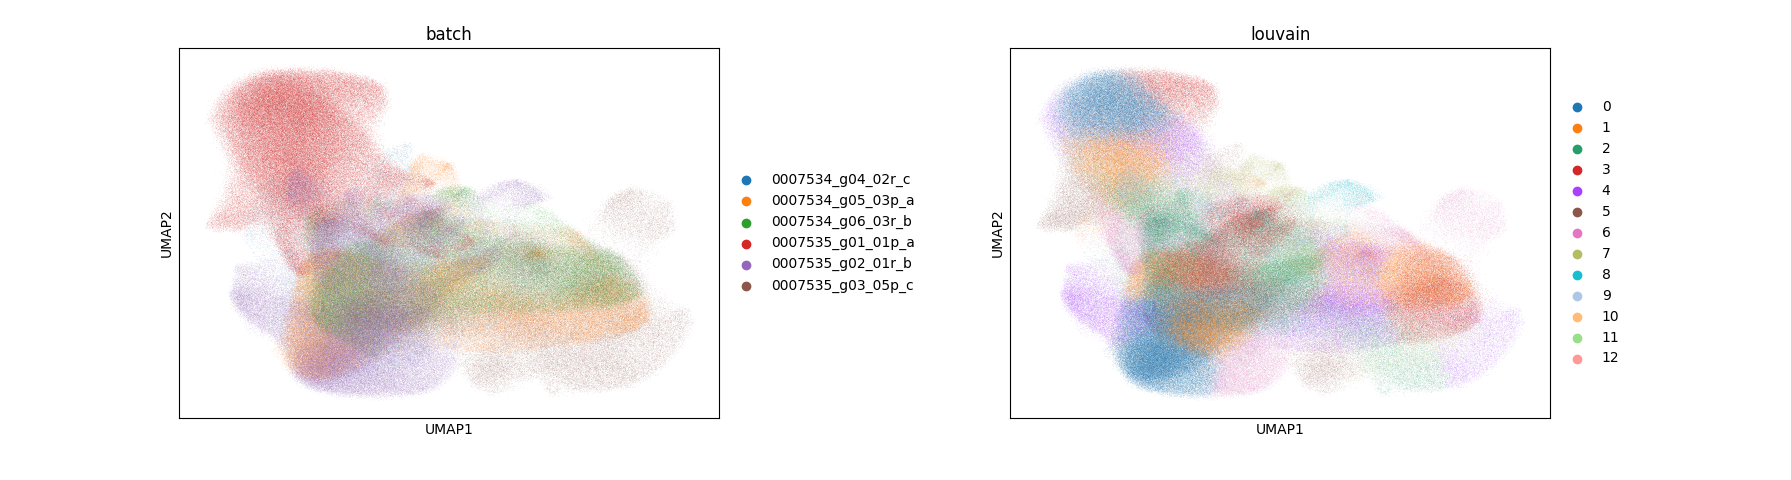

In [10]:
Image("D:/Projects/Xenium/figs/integrated_umap.png")

In [6]:
"""
sc.pp.pca(adata_combined)
sc.pp.neighbors(adata_combined)
# sc.tl.tsne(adata_combined)
sc.tl.umap(adata_combined)
sc.tl.leiden(adata_combined)
sc.tl.louvain(adata_combined)
sc.pl.umap(adata_combined, color=['batch','louvain'], wspace=0.4)
"""

"\nsc.pp.pca(adata_combined)\nsc.pp.neighbors(adata_combined)\n# sc.tl.tsne(adata_combined)\nsc.tl.umap(adata_combined)\nsc.tl.leiden(adata_combined)\nsc.tl.louvain(adata_combined)\nsc.pl.umap(adata_combined, color=['batch','louvain'], wspace=0.4)\n"

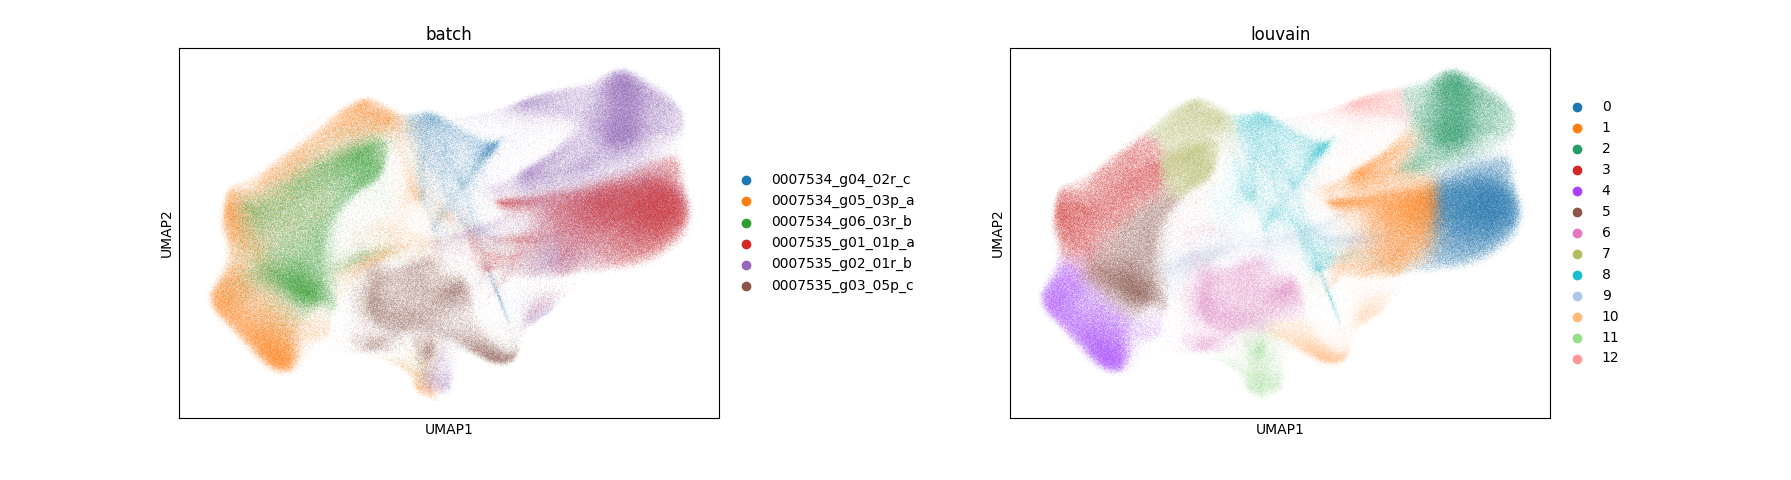

In [11]:
Image("D:/Projects/Xenium/figs/Integrated_PCA_umap.png")

In [7]:
"""
sc.pp.pca(adata_combined)
sc.pp.neighbors(adata_combined)
sc.external.pp.bbknn(adata_combined, batch_key='batch')
sc.tl.umap(adata_combined)
sc.tl.leiden(adata_combined)
sc.tl.louvain(adata_combined)
sc.pl.umap(adata_combined, color=['batch','louvain'], wspace=0.4)
"""

"\nsc.pp.pca(adata_combined)\nsc.pp.neighbors(adata_combined)\nsc.external.pp.bbknn(adata_combined, batch_key='batch')\nsc.tl.umap(adata_combined)\nsc.tl.leiden(adata_combined)\nsc.tl.louvain(adata_combined)\nsc.pl.umap(adata_combined, color=['batch','louvain'], wspace=0.4)\n"

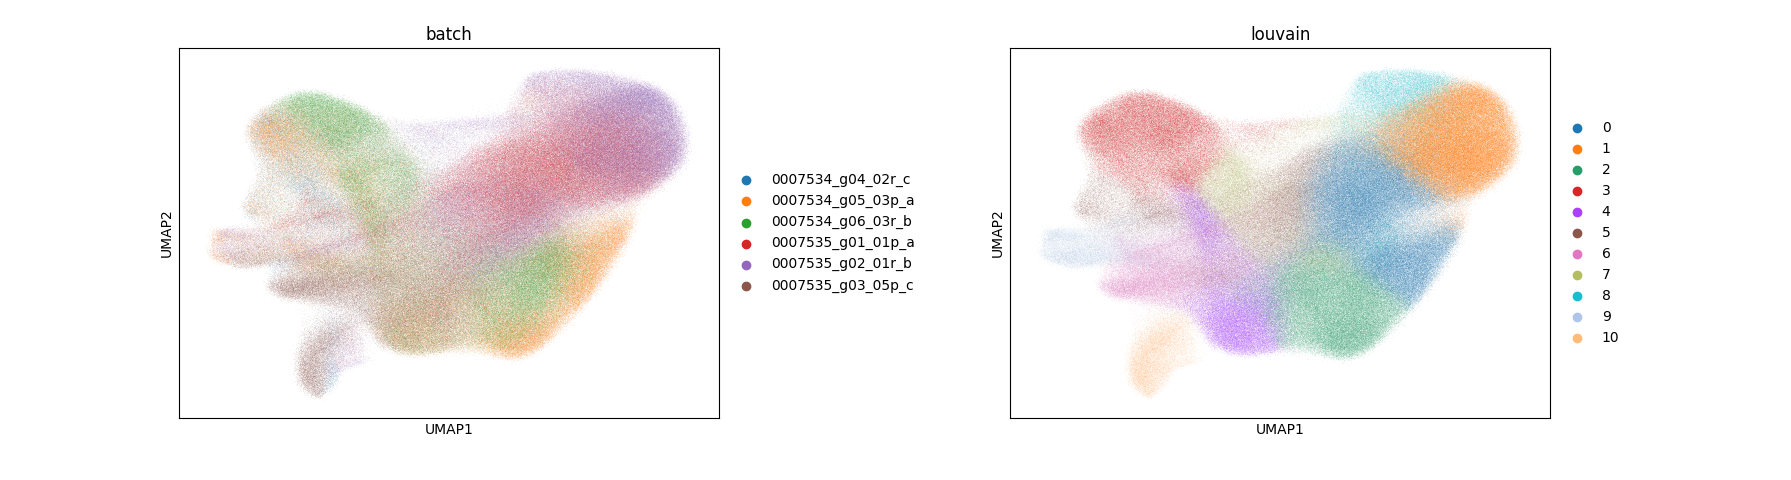

In [12]:
Image("D:/Projects/Xenium/figs/Integrated_PCA_BBKNN_umap.png")

In [13]:
adata_combined = sc.read(os.path.join(data_root, "combined_adata_bbknn.h5ad"))

In [14]:
# Splitting observations into subgroups based on the 'batch' metadata
batches = adata_combined.obs['batch'].unique()  # Get unique group values
adatas = {}
for batch in batches:
    subgroup_mask = adata_combined.obs['batch'] == batch  # Create a boolean mask for the current group
    subgroup_data = adata_combined[subgroup_mask].copy()  # Create a copy of the data for the subgroup
    adatas[batch] = subgroup_data  # Store the subgroup data in a dictionary
print(adatas)

{'0007534_g04_02r_c': AnnData object with n_obs × n_vars = 36095 × 366
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'louvain', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts-0007534_g04_02r_c', 'mean_counts-0007534_g04_02r_c', 'log1p_mean_counts-0007534_g04_02r_c', 'pct_dropout_by_counts-0007534_g04_02r_c', 'total_counts-0007534_g04_02r_c', 'log1p_total_counts-0007534_g04_02r_c', 'n_cells-0007534_g04_02r_c', 'n_cells_by_counts-0007534_g05_03p_a', 'mean_counts-0007534_g05_03p_a', 'log1p_mean_counts-0007534_g05_03p_a', 'pct_dropout_by_counts-0007534_g05_03p_a', 'total_counts-0007534_g05_03p_a', 'log1p_to

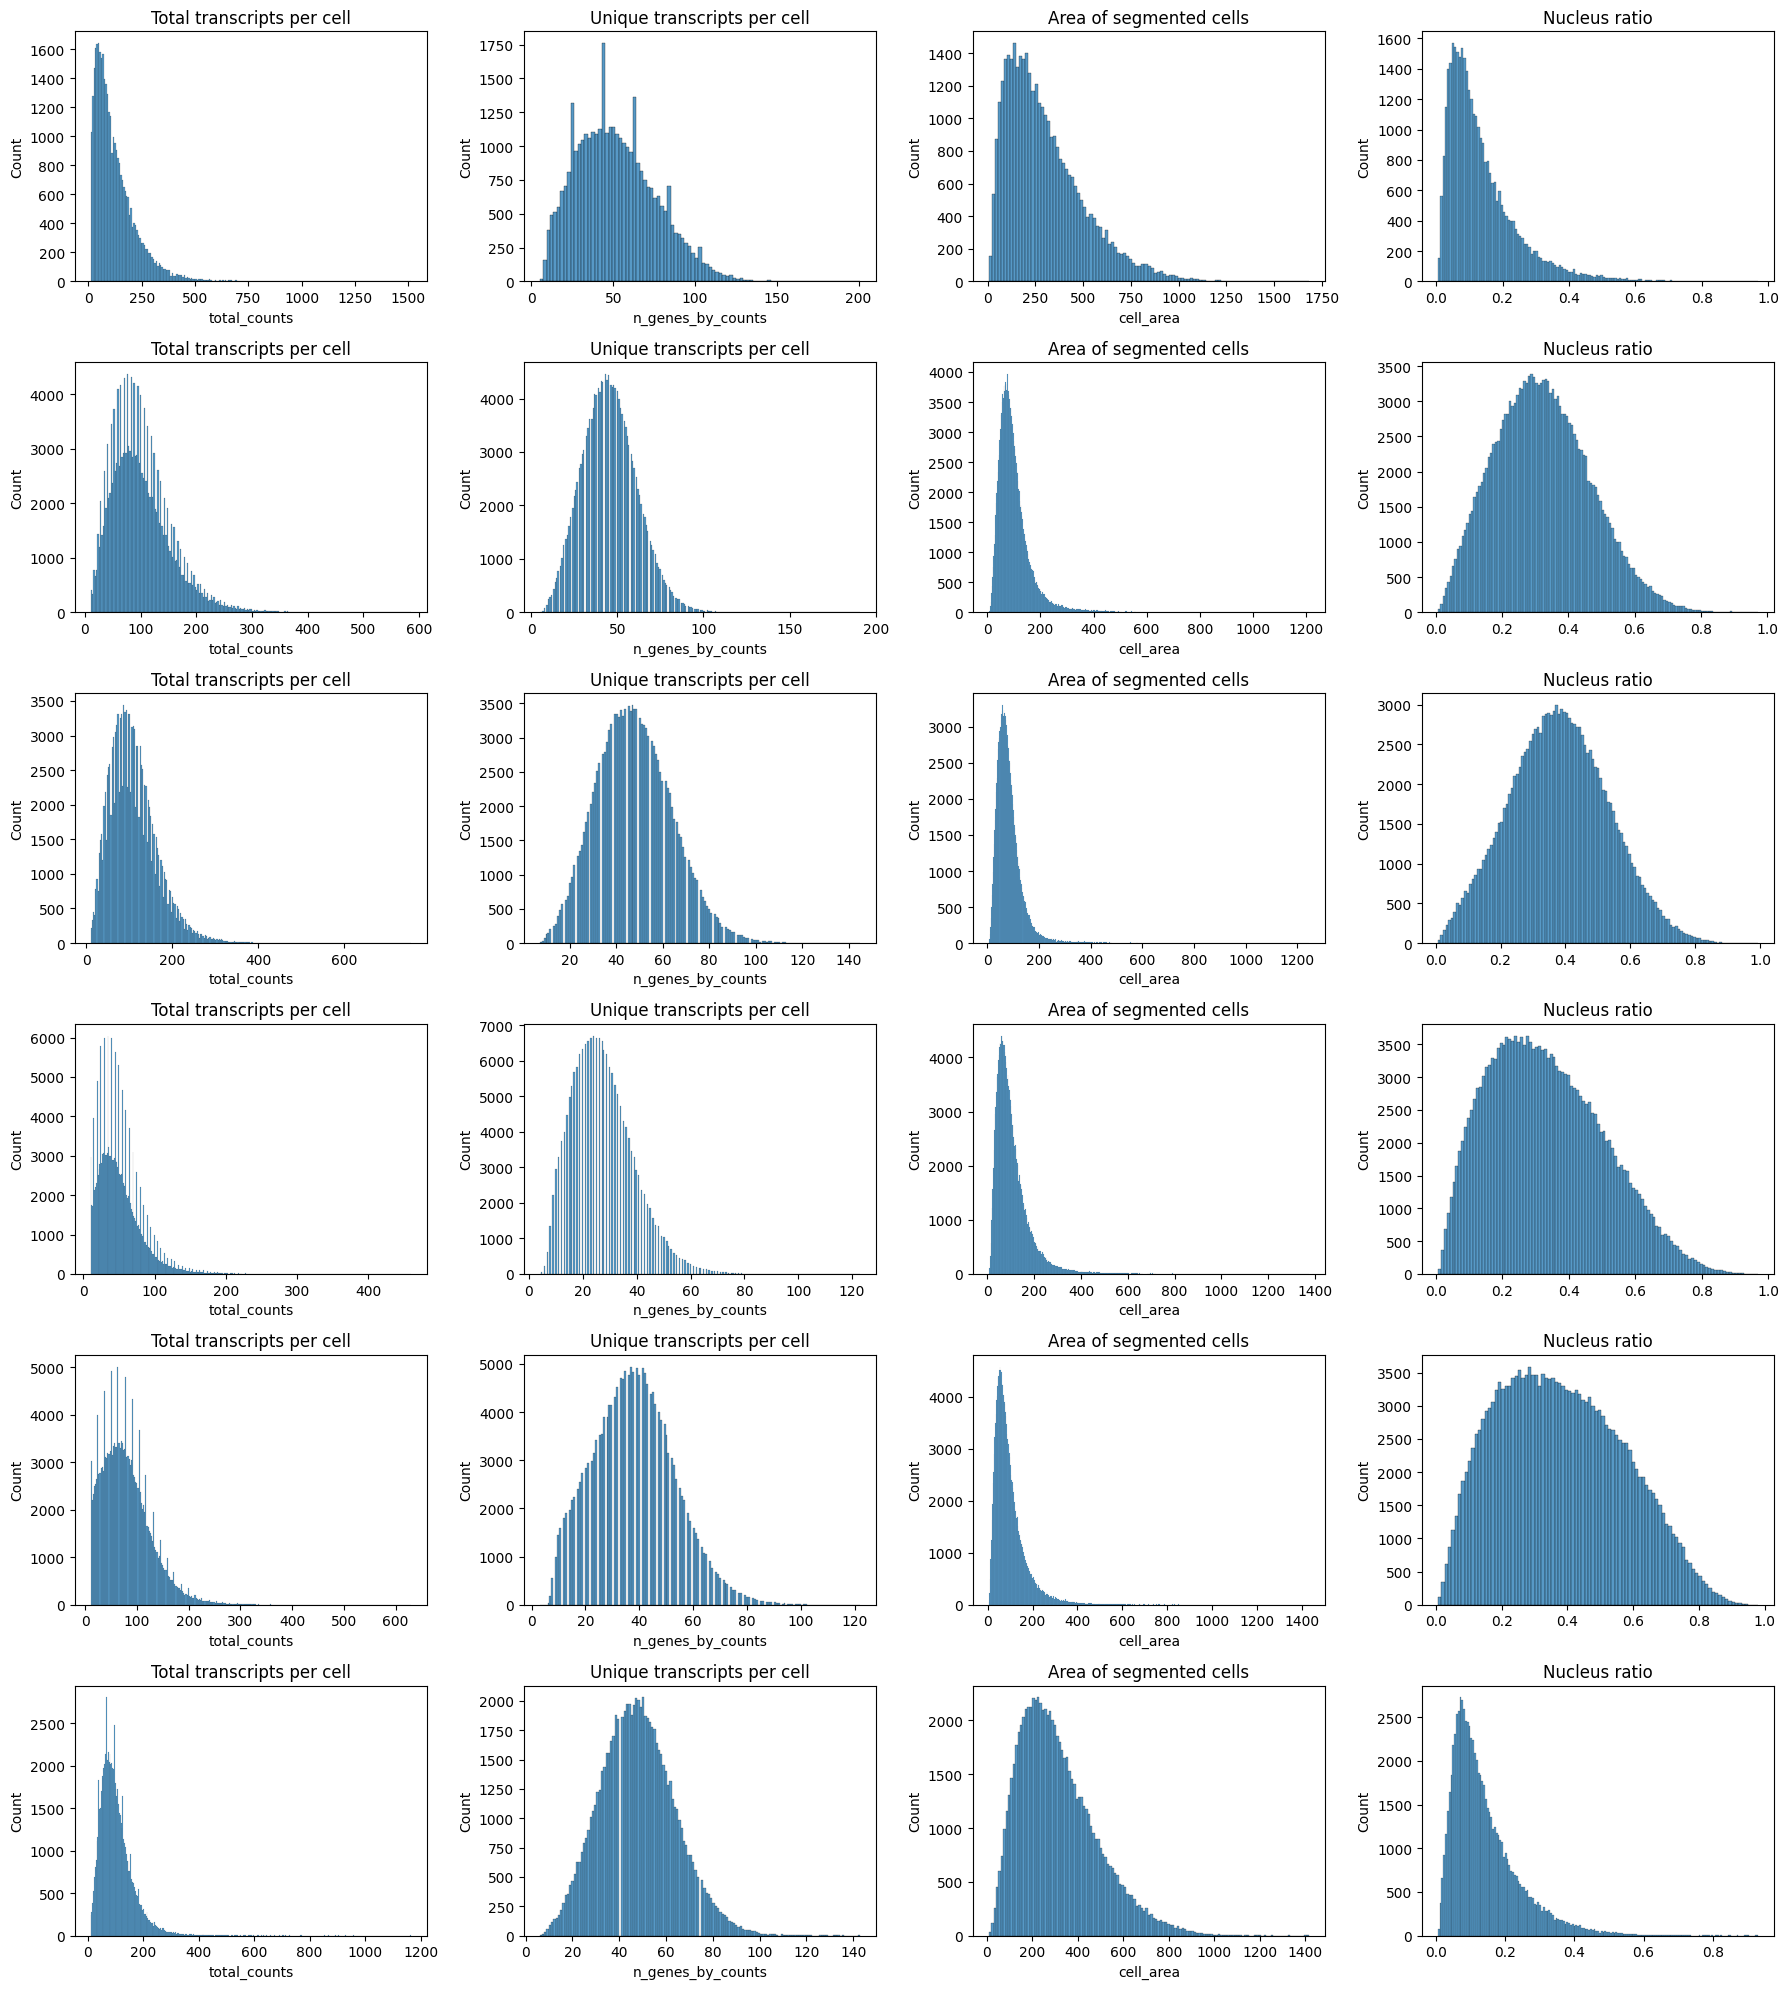

In [15]:
# Plot distribution of total transcripts per cell
n_cols = 4
n_rows = len(batches)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_rows * 3, n_cols * 5))
for i, batch_id in enumerate(batches):
    # Create a mask for the current batch
    adata = adatas[batch_id]
    axes[i, 0].set_title("Total transcripts per cell")
    sns.histplot(adata.obs["total_counts"], kde=False, ax=axes[i, 0])
    axes[i, 1].set_title("Unique transcripts per cell")
    sns.histplot(adata.obs["n_genes_by_counts"], kde=False, ax=axes[i, 1])
    axes[i, 2].set_title("Area of segmented cells")
    sns.histplot(adata.obs["cell_area"], kde=False, ax=axes[i, 2])
    axes[i, 3].set_title("Nucleus ratio")
    sns.histplot(adata.obs["nucleus_area"] / adata.obs["cell_area"], kde=False, ax=axes[i, 3])
plt.tight_layout()
plt.show()

C:\Users\jocke\Anaconda3\envs\Xenium\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\jocke\Anaconda3\envs\Xenium\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


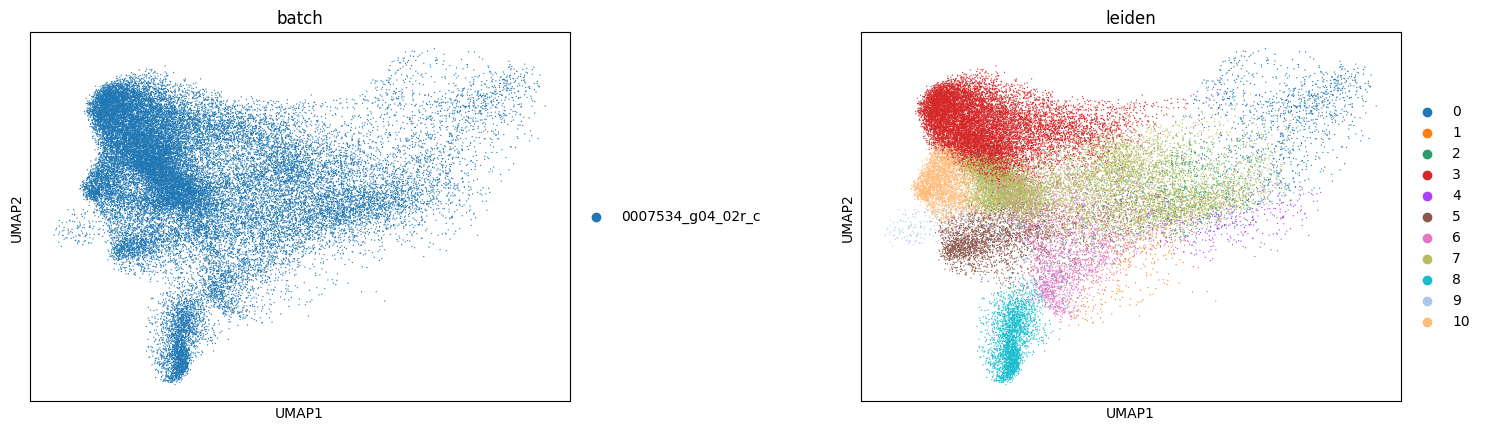

C:\Users\jocke\Anaconda3\envs\Xenium\lib\site-packages\squidpy\pl\_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


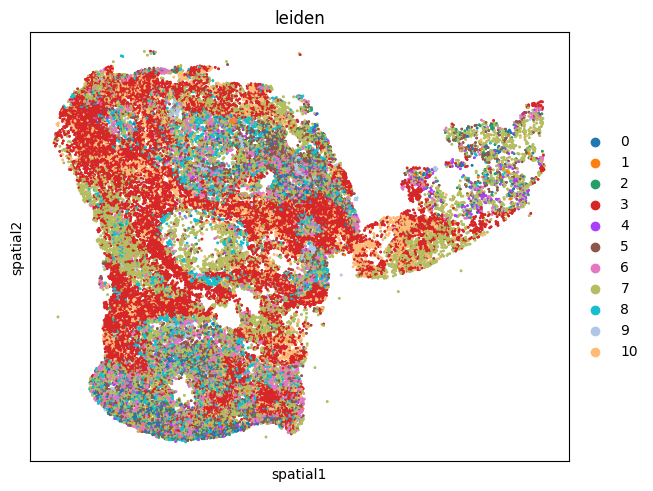

In [17]:
# %% Plot examples
sc.pl.umap(adatas[batches[0]], color=['batch','leiden'], wspace=0.4)
sq.pl.spatial_scatter(adatas[batches[0]], library_id="spatial", shape=None, color=["leiden"], wspace=0.4)
plt.show()

In [ ]:
adata_combined = sc.read(os.path.join(data_root, data,"combined_adata_bbknn_processed all.h5ad"))

In [ ]:
sc.pl.violin(adata_combined, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)